In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import random
from tqdm import tqdm
import featuretools as ft
from joblib import dump, load
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, power_transform, quantile_transform, normalize 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import  QuantileTransformer, PowerTransformer

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    
import warnings
warnings.filterwarnings(
    action='ignore',
)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
metadata = pd.read_csv('data/metadata.csv')
sup_metadata = pd.read_csv('data/supplemental_metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('data/val_labels.csv',index_col='sample_id')
targets = pd.read_csv('targets.csv',index_col='sample_id')
submission_format = pd.read_csv('data/submission_format.csv')

In [3]:
train_50 = pd.read_csv('train/train_50.csv',index_col=0,header=[0,1])
val_50 = pd.read_csv('train/val_50.csv',index_col=0,header=[0,1])
test_50 = pd.read_csv('test/test_df_50.csv',index_col=0,header=[0,1])

train_50.sort_index(axis=1,inplace=True)
val_50.sort_index(axis=1,inplace=True)
test_50.sort_index(axis=1,inplace=True)

val_50.index = metadata[metadata.split == 'val'].index

In [4]:
train_set_50 = pd.concat([train_50,val_50],axis=0)
test_set_50 = pd.concat([val_50,test_50],axis=0)
train_set_50.shape, test_set_50.shape

((1059, 4200), (804, 4200))

In [5]:
train_temp_100 = pd.read_csv('train/train_temp_qt_v1_100.csv',index_col=0,header=[0,1])
val_temp_100 = pd.read_csv('train/val_temp_qt_v1_100.csv',index_col=0,header=[0,1])
test_temp_100 = pd.read_csv('test/test_temp_qt_v1_100.csv',index_col=0,header=[0,1])

train_temp_100.sort_index(axis=1,inplace=True)
val_temp_100.sort_index(axis=1,inplace=True)
test_temp_100.sort_index(axis=1,inplace=True)

val_temp_100.index = metadata[metadata.split == 'val'].index

In [6]:
train_temp_100

m/z               0                                                    \
time_bin   (0, 100] (100, 200] (1000, 1100] (1100, 1200] (1200, 1300]   
sample_id                                                               
0          0.972446   0.973660     0.000000          0.0          0.0   
1          0.000000   0.000000     0.000000          0.0          0.0   
2          0.967432   0.969142     0.000000          0.0          0.0   
3          0.938054   0.949867     0.884606          0.0          0.0   
4          0.964857   0.976988     0.884453          0.0          0.0   
...             ...        ...          ...          ...          ...   
761        0.000000   0.000000     0.000000          0.0          0.0   
762        0.000000   0.000000     0.000000          0.0          0.0   
763        0.000000   0.000000     0.000000          0.0          0.0   
764        0.000000   0.000000     0.000000          0.0          0.0   
765        0.000000   0.000000     0.000000          0.0          0.0   

m/z                                                                     ...  \
time_bin  (1300, 1400] (1400, 1500] (1500, 1600] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
0                  0.0          0.0          0.0   0.957370   0.903603  ...   
1                  0.0          0.0          0.0   0.000000   0.000000  ...   
2                  0.0          0.0          0.0   0.963602   0.939051  ...   
3                  0.0          0.0          0.0   0.930984   0.924607  ...   
4                  0.0          0.0          0.0   0.972669   0.961530  ...   
...                ...          ...          ...        ...        ...  ...   
761                0.0          0.0          0.0   0.000000   0.000000  ...   
762                0.0          0.0          0.0   0.000000   0.000000  ...   
763                0.0          0.0          0.0   0.000000   0.000000  ...   
764                0.0          0.0          0.0   0.000000   0.000000  ...   
765                0.0          0.0          0.0   0.000000   0.000000  ...   

m/z                 99                                                \
time_bin  (1400, 1500] (1500, 1600] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
0                  0.0          0.0   0.485371   0.479781   0.000000   
1                  0.0          0.0   0.000000   0.000000   0.000000   
2                  0.0          0.0   0.480093   0.514519   0.522877   
3                  0.0          0.0   0.526299   0.574225   0.545225   
4                  0.0          0.0   0.457591   0.450299   0.486543   
...                ...          ...        ...        ...        ...   
761                0.0          0.0   0.277277   0.250250   0.250250   
762                0.0          0.0   0.182683   0.134134   0.239740   
763                0.0          0.0   0.164665   0.176176   0.164665   
764                0.0          0.0   0.199700   0.312813   0.312813   
765                0.0          0.0   0.266767   0.226226   0.305806   

m/z                                                                
time_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
0           0.000000   0.000000   0.000000   0.000000    0.000000  
1           0.000000   0.000000   0.000000   0.000000    0.000000  
2           0.505402   0.484424   0.573439   0.546809    0.549400  
3           0.553812   0.540699   0.521665   0.528313    0.490145  
4           0.503662   0.396654   0.475675   0.478454    0.423608  
...              ...        ...        ...        ...         ...  
761         0.277277   0.250250   0.313814   0.277277    0.250250  
762         0.158158   0.410410   0.105606   0.182683    0.158158  
763         0.164665   0.241742   0.164665   0.164665    0.229229  
764         0.260260   0.260260   0.260260   

In [6]:
%%time
test_100 = pd.read_csv('test/test_100.csv',index_col=0,header=[0,1])
train_100 = pd.read_csv('train/train_100.csv',index_col=0,header=[0,1])
val_100 = pd.read_csv('train/val_100.csv',index_col=0,header=[0,1])

val_100.index = metadata[metadata.split == 'val'].sample_id

val_100.sort_index(inplace=True,axis=1)
test_100.sort_index(inplace=True,axis=1)
train_100.sort_index(inplace=True,axis=1)

Wall time: 807 ms


In [7]:
train_set_100 = pd.concat([train_100,val_100],axis=0)
test_set_100 = pd.concat([val_100,test_100],axis=0)
train_set_100.shape, test_set_100.shape

((1059, 1600), (804, 1600))

In [7]:
train_temp = pd.read_csv('train/train_temp_df_0.csv',index_col=0,header=[0,1])
train_temp

In [ ]:
val_temp_1 = pd.read_csv('train/val_temp_df_1.csv',index_col=0,header=[0,1])
val_temp_1

In [11]:
val_temp_0 = pd.read_csv('train/val_temp_df_0.csv',index_col=0,header=[0,1])
val_temp_0

m/z            0                                                         \
time_bin  (0, 5] (5, 10] (10, 15] (15, 20] (20, 25]  (25, 30]  (30, 35]   
sample_id                                                                 
766          0.0     0.0      0.0      0.0      0.0  0.341912  0.382952   
767          0.0     0.0      0.0      0.0      0.0  0.030629  0.034917   
768          0.0     0.0      0.0      0.0      0.0  0.000000  0.020703   
769          0.0     0.0      0.0      0.0      0.0  0.000000  0.000000   
770          0.0     0.0      0.0      0.0      0.0  0.000000  0.002402   
...          ...     ...      ...      ...      ...       ...       ...   
1054         0.0     0.0      0.0      0.0      0.0  0.000000  0.080542   
1055         0.0     0.0      0.0      0.0      0.0  0.000000  0.027540   
1056         0.0     0.0      0.0      0.0      0.0  0.000139  0.000111   
1057         0.0     0.0      0.0      0.0      0.0  0.000030  0.000064   
1058         0.0     0.0      0.0      0.0      0.0  0.000000  0.001484   

m/z                                      ...           99               \
time_bin   (35, 40]  (40, 45]  (45, 50]  ... (2450, 2455] (2455, 2460]   
sample_id                                ...                             
766        0.287615  0.252394  0.260791  ...          0.0          0.0   
767        0.042661  0.044839  0.055936  ...          0.0          0.0   
768        0.024932  0.009537  0.009095  ...          0.0          0.0   
769        0.000000  0.000000  0.000000  ...          0.0          0.0   
770        0.002322  0.002379  0.002373  ...          0.0          0.0   
...             ...       ...       ...  ...          ...          ...   
1054       0.049809  0.081429  0.079149  ...          0.0          0.0   
1055       0.037724  0.020903  0.027005  ...          0.0          0.0   
1056       0.000076  0.000134  0.000130  ...          0.0          0.0   
1057       0.000036  0.000031  0.000021  ...          0.0          0.0   
1058       0.001534  0.001047  0.000998  ...          0.0          0.0   

m/z                                                                         \
time_bin  (2460, 2465] (2465, 2470] (2470, 2475] (2475, 2480] (2480, 2485]   
sample_id                                                                    
766                0.0          0.0          0.0          0.0          0.0   
767                0.0          0.0          0.0          0.0          0.0   
768                0.0          0.0          0.0          0.0          0.0   
769                0.0          0.0          0.0          0.0          0.0   
770                0.0          0.0          0.0          0.0          0.0   
...                ...          ...          ...          ...          ...   
1054               0.0          0.0          0.0          0.0          0.0   
1055               0.0          0.0          0.0          0.0          0.0   
1056               0.0          0.0          0.0          0.0          0.0   
1057               0.0          0.0          0.0          0.0          0.0   
1058               0.0          0.0          0.0          0.0          0.0   

m/z                                               
time_bin  (2485, 2490] (2490, 2495] (2495, 2500]  
sample_id                                         
766                0.0          0.0          0.0  
767                0.0          0.0          0.0  
768                0.0          0.0          0.0  
769                0.0          0.0          0.0  
770                0.0          0.0          0.0  
...                ...          ...          ...  
1054               0.0          0.0          0.0  
1055               0.0          0.0          0.0  
1056               0.0          0.0          0.0  
1057               0.0          0.0          0.0  
1058               0.0          0.0          0.0  

[293 rows x 50000 columns]

# cv

In [59]:
train_100 = pd.read_csv('train/train_100.csv', index_col=0,header=[0,1])
val_100 = pd.read_csv('train/val_100.csv', index_col=0,header=[0,1])
test_100 = pd.read_csv('test/test_100.csv', index_col=0,header=[0,1])

train_100.sort_index(axis=1,inplace=True)
val_100.sort_index(axis=1,inplace=True)
test_100.sort_index(axis=1,inplace=True)

In [60]:
train_set_100 = pd.concat([train_100,val_100],axis=0)
test_set_100 = pd.concat([val_100,test_100],axis=0)
train_set_100.shape, test_set_100.shape

((1059, 1600), (804, 1600))

In [8]:
train_he = pd.read_csv('train_100_he.csv', index_col=0,header=[0,1])
val_he = pd.read_csv('val_100_he.csv', index_col=0,header=[0,1])
test_he = pd.read_csv('test_100_he.csv', index_col=0,header=[0,1])

train_he.sort_index(axis=1,inplace=True)
val_he.sort_index(axis=1,inplace=True)
test_he.sort_index(axis=1,inplace=True)

In [9]:
skf = StratifiedKFold(n_splits=5,random_state=RANDOM_SEED,shuffle=True)
log_loss_scorer = make_scorer(log_loss,needs_proba=True)

In [19]:
phy = 'phyllosilicate'
bas = 'basalt'
lr = LogisticRegression(solver='liblinear',C=10,random_state=RANDOM_SEED,penalty='l1')
lr

LogisticRegression(C=10, penalty='l1', random_state=777, solver='liblinear')

In [13]:
def get_relhe_abund(df):
    rel_df = pd.DataFrame(index = df.index,columns = df.columns)
    df_4 = df[get_mz(4,df)]
    for i in tqdm(range(100)):
        df_i = df[get_mz(i,df)]
        df_i_values = df_4.values - df_i.values
        rel_df[get_mz(i,rel_df)] = df_i_values
    return rel_df

In [14]:
def get_coefs(X,y,c=10):
    lr = LogisticRegression(solver='liblinear',C=c,random_state=RANDOM_SEED,penalty='l1')
    print(cross_val_score(lr,X,y,cv=skf,scoring=log_loss_scorer).mean())
    lr.fit(X,y)
    # print(log_loss(y,lr.predict_proba(X)))
    coefs =  lr.coef_
    coefs_list  = []
    for id,wt in enumerate(tqdm(coefs[0])):             
        if wt != 0:
            coefs_list.append(id)
    print(len(coefs_list))
    return coefs_list

In [15]:
def get_mz(mz,df):
    ''' returns list of columns for given mz'''
    cols_list = []
    for col in df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [16]:
def get_total_abundance(df):
    ''' returns total abundance for each sample'''
    tot_abund_df = pd.DataFrame(index=df.index)
    tot_abund_df['tot_abund'] = df.sum(axis=1)
    for mz in tqdm(range(0,100)):
        tot_abund_df[f"tot_abund_{mz}"] = df[get_mz(mz,df)].sum(axis=1)
    print(tot_abund_df.shape)
    return tot_abund_df

In [17]:
def get_grads(df,bin_size=5):
    ''' returns gradients for each mz'''
    grad_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        # df_mz_col1 = df_mz.iloc[:,0].values
        df_mz = df_mz.diff(axis=1)
        # df_mz.iloc[:,0] = df_mz_col1
        df_mz.dropna(axis='columns',inplace=True)
        # df_mz = df_mz/bin_size
        df_mz.columns = [col[0]+ '_' + col[1] + '_' + 'grad' for col in df_mz.columns]
        grad_df = pd.concat([grad_df,df_mz],axis=1)
    print(grad_df.shape)

    return  grad_df

In [18]:
def get_mean_std(df):
    ''' returns mean and std for each mz'''
    mean_std_df = pd.DataFrame(index=df.index)
    temp = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        temp[f'{mz}_mean'] = df_mz.mean(axis=1)
        temp[f'{mz}_std'] = df_mz.std(axis=1)
        # mean_std_df = pd.concat([mean_std_df,temp],axis=1)
    print(temp.shape)
    return temp

100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


(1059, 200)


<AxesSubplot:xlabel='sample_id'>

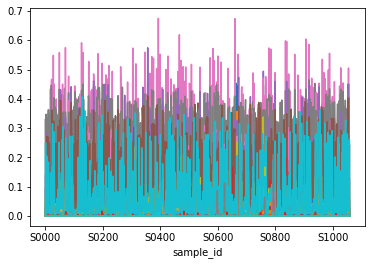

In [39]:
m = get_mean_std(train_set_100)
m.plot(legend=False)

In [73]:
train_set_100

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.004085   0.004641     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.002270   0.002495     0.000000          0.0   
S0003           0.0  0.001336   0.002464     0.000306          0.0   
S0004           0.0  0.005993   0.012429     0.000593          0.0   
...             ...       ...        ...          ...          ...   
1054            0.0  0.129083   0.131998     0.096385          0.0   
1055            0.0  0.037724   0.036757     0.020977          0.0   
1056            0.0  0.000371   0.001633     0.000016          0.0   
1057            0.0  0.000235   0.000496     0.000063          0.0   
1058            0.0  0.003384   0.004575     0.006704          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.001394   0.000188  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.001688   0.000636  ...   
S0003              0.0          0.0          0.0   0.001099   0.000992  ...   
S0004              0.0          0.0          0.0   0.009380   0.005099  ...   
...                ...          ...          ...        ...        ...  ...   
1054               0.0          0.0          0.0   0.157281   0.156331  ...   
1055               0.0          0.0          0.0   0.042467   0.046966  ...   
1056               0.0          0.0          0.0   0.000520   0.000234  ...   
1057               0.0          0.0          0.0   0.000999   0.002152  ...   
1058               0.0          0.0          0.0   0.005057   0.005892  ...   

m/z                 99                                                   \
temp_bin  (1300, 1400] (1400, 1500]    (200, 300] (300, 400] (400, 500]   
sample_id                                                                 
S0000              0.0          0.0  2.898509e-06   0.000003   0.000000   
S0001              0.0          0.0  0.000000e+00   0.000000   0.000000   
S0002              0.0          0.0  9.257968e-07   0.000001   0.000001   
S0003              0.0          0.0  4.379099e-06   0.000006   0.000005   
S0004              0.0          0.0  3.904920e-06   0.000004   0.000004   
...                ...          ...           ...        ...        ...   
1054               0.0          0.0  3.437657e-04   0.000236   0.000353   
1055               0.0          0.0  1.277169e-04   0.000127   0.000225   
1056               0.0          0.0  2.138303e-06   0.000003   0.000003   
1057               0.0          0.0  1.382588e-06   0.000002   0.000001   
1058               0.0          0.0  1.827355e-05   0.000018   0.000010   

m/z                                                                   
temp_bin  (500, 600]    (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                             
S0000       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0001       0.000000  0.000000e+00   0.000000   0.000000    0.000000  
S0002       0.000001  9.397170e-07   0.000001   0.000001    0.000001  
S0003       0.000005  4.693477e-06   0.000004   0.000004    0.000004  
S0004       0.000005  3.174421e-06   0.000004   0.000004    0.000003  
...              ...           ...        ...        ...         ...  
1054        0.000350  2.672030e-04   0.000363   0.000355    0.000282  
1055        0.000165  2.020603e-04   0.000148   0.000145    0.000142  
1056        0.000003  2.037079e-06   0.000003   0.000002    0.000002  
1057     

In [72]:
sns.kdeplot(train_set_100)

ValueError: If using all scalar values, you must pass an index

 29%|██▉       | 29/100 [00:00<00:00, 287.40it/s]

(1059, 1600)


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


(1059, 200)


<AxesSubplot:xlabel='sample_id'>

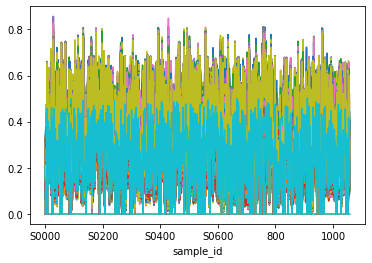

In [63]:
qt_100 = qt(train_set_100,'uniform')
m_qt = get_mean_std(qt_100)
m_qt.plot(legend=False)

In [ ]:
m_qt.iloc

 30%|███       | 30/100 [00:00<00:00, 292.97it/s]

(1059, 1600)


100%|██████████| 100/100 [00:02<00:00, 42.97it/s]


(1059, 200)


<AxesSubplot:xlabel='sample_id'>

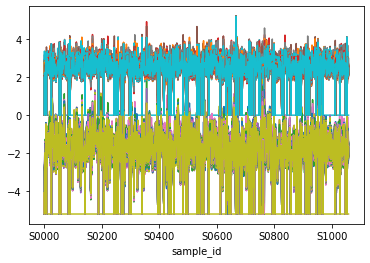

In [46]:
qt_100 = qt(train_set_100,'normal')
m_qt = get_mean_std(qt_100)
m_qt.plot(legend=False)

<AxesSubplot:>

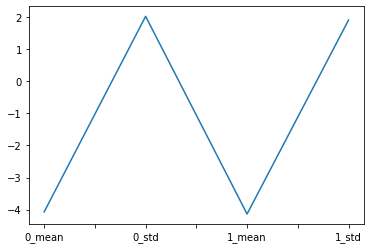

In [56]:
m_qt.iloc[0,0:4].plot(legend=False)

In [47]:
for col in qt_100.columns:
    qt_100[col] = rank_gauss(qt_100[col].values)

100%|██████████| 100/100 [00:02<00:00, 45.62it/s]


(1059, 200)


<AxesSubplot:xlabel='sample_id'>

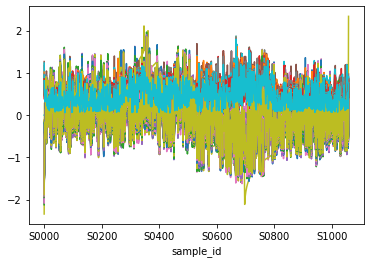

In [48]:
rg = get_mean_std(qt_100)
rg.plot(legend=False)

In [61]:
x = train_set_100.copy(deep=True)
for col in x.columns:
    x[col] = rank_gauss(x[col].values) 

100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


(1059, 200)


<AxesSubplot:xlabel='sample_id'>

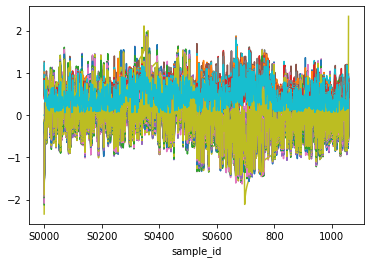

In [62]:
mx = get_mean_std(x)
mx.plot(legend=False)

In [64]:
x  = quantile_transform(train_set_100)
x

array([[0.        , 0.41274493, 0.35726547, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.31691505, 0.25782433, ..., 0.15993683, 0.1575287 ,
        0.2353135 ],
       ...,
       [0.        , 0.15022637, 0.20320851, ..., 0.23072551, 0.207178  ,
        0.2810072 ],
       [0.        , 0.11911443, 0.12707576, ..., 0.18815384, 0.18811941,
        0.26024045],
       [0.        , 0.3801473 , 0.35536575, ..., 0.43035369, 0.44241459,
        0.55675364]])

In [65]:
x = pd.DataFrame(x,index=train_set_100.index,columns=train_set_100.columns)
x

m/z               0                                                 \
temp_bin  (-100, 0]  (0, 100] (100, 200] (1000, 1100] (1100, 1200]   
sample_id                                                            
S0000           0.0  0.412745   0.357265     0.000000          0.0   
S0001           0.0  0.000000   0.000000     0.000000          0.0   
S0002           0.0  0.316915   0.257824     0.000000          0.0   
S0003           0.0  0.257205   0.253290     0.469745          0.0   
S0004           0.0  0.502499   0.542519     0.519347          0.0   
...             ...       ...        ...          ...          ...   
1054            0.0  0.950534   0.939949     0.948970          0.0   
1055            0.0  0.820046   0.788773     0.846908          0.0   
1056            0.0  0.150226   0.203209     0.419818          0.0   
1057            0.0  0.119114   0.127076     0.428219          0.0   
1058            0.0  0.380147   0.355366     0.769731          0.0   

m/z                                                                     ...  \
temp_bin  (1200, 1300] (1300, 1400] (1400, 1500] (200, 300] (300, 400]  ...   
sample_id                                                               ...   
S0000              0.0          0.0          0.0   0.198987   0.093172  ...   
S0001              0.0          0.0          0.0   0.000000   0.000000  ...   
S0002              0.0          0.0          0.0   0.217532   0.148498  ...   
S0003              0.0          0.0          0.0   0.181854   0.178221  ...   
S0004              0.0          0.0          0.0   0.501386   0.397702  ...   
...                ...          ...          ...        ...        ...  ...   
1054               0.0          0.0          0.0   0.948090   0.949900  ...   
1055               0.0          0.0          0.0   0.806945   0.823753  ...   
1056               0.0          0.0          0.0   0.126418   0.101132  ...   
1057               0.0          0.0          0.0   0.173453   0.251923  ...   
1058               0.0          0.0          0.0   0.386528   0.424712  ...   

m/z                 99                                                \
temp_bin  (1300, 1400] (1400, 1500] (200, 300] (300, 400] (400, 500]   
sample_id                                                              
S0000              0.0          0.0   0.220220   0.220222   0.000000   
S0001              0.0          0.0   0.000000   0.000000   0.000000   
S0002              0.0          0.0   0.117714   0.125361   0.138066   
S0003              0.0          0.0   0.270278   0.298407   0.283838   
S0004              0.0          0.0   0.251254   0.246425   0.268669   
...                ...          ...        ...        ...        ...   
1054               0.0          0.0   0.876107   0.840891   0.872437   
1055               0.0          0.0   0.769821   0.777642   0.833803   
1056               0.0          0.0   0.175426   0.217492   0.211114   
1057               0.0          0.0   0.142389   0.152153   0.149455   
1058               0.0          0.0   0.523628   0.513701   0.402619   

m/z                                                                
temp_bin  (500, 600] (600, 700] (700, 800] (800, 900] (900, 1000]  
sample_id                                                          
S0000       0.000000   0.000000   0.000000   0.000000    0.000000  
S0001       0.000000   0.000000   0.000000   0.000000    0.000000  
S0002       0.143213   0.145424   0.159937   0.157529    0.235313  
S0003       0.303532   0.294744   0.282304   0.287418    0.347238  
S0004       0.299633   0.248405   0.278263   0.281364    0.331212  
...              ...        ...        ...        ...         ...  
1054        0.875508   0.851837   0.881860   0.878890    0.871365  
1055        0.798700   0.820993   0.785602   0.784253    0.799716  
1056        0.214826   0.196001   0.230726   0.207178    0.281007  
1057        0.177475   0.178782   0.188154   0.188119    0.260240  
1058        0.44228

<AxesSubplot:xlabel='sample_id'>

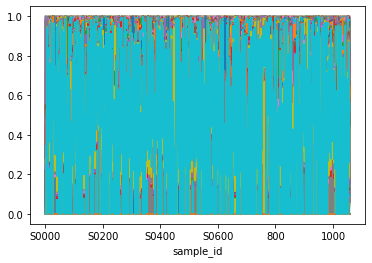

In [66]:
x.plot(legend=False)

In [67]:
x_mean = get_mean_std(x)
x_mean

100%|██████████| 100/100 [00:02<00:00, 47.79it/s]

(1059, 200)


,0_mean,0_std,1_mean,1_std,2_mean,2_std,3_mean,3_std,4_mean,4_std,...,95_mean,95_std,96_mean,96_std,97_mean,97_std,98_mean,98_std,99_mean,99_std
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,0.066386,0.135588,0.048662,0.103198,0.015588,0.036134,0.014010,0.025345,0.0,0.0,...,0.055336,0.099135,0.064400,0.115346,0.057679,0.103813,0.056431,0.101339,0.058548,0.105013
S0001,0.000000,0.000000,0.119902,0.247418,0.243410,0.342241,0.130644,0.247866,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
S0002,0.120566,0.106606,0.120561,0.109196,0.067853,0.061502,0.082467,0.069050,0.0,0.0,...,0.090631,0.076222,0.092751,0.078707,0.093286,0.078520,0.093759,0.078673,0.091781,0.078112
S0003,0.163792,0.134041,0.159535,0.132279,0.142216,0.124667,0.156588,0.129083,0.0,0.0,...,0.222456,0.164739,0.203556,0.154117,0.213064,0.158589,0.203419,0.151842,0.214124,0.159382
S0004,0.266244,0.212526,0.271886,0.215963,0.224724,0.175156,0.238630,0.184895,0.0,0.0,...,0.196321,0.147407,0.207550,0.152393,0.208921,0.159576,0.209272,0.154778,0.205403,0.158020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0.646646,0.450337,0.642445,0.447421,0.628729,0.438089,0.638965,0.444988,0.0,0.0,...,0.599023,0.417589,0.602995,0.419988,0.604867,0.421338,0.600577,0.418296,0.601214,0.418881
1055,0.558399,0.389295,0.559652,0.390201,0.530923,0.370835,0.569252,0.396932,0.0,0.0,...,0.546917,0.381261,0.539349,0.376402,0.543932,0.379082,0.550514,0.383709,0.548859,0.382581
1056,0.146015,0.126773,0.139968,0.132025,0.108627,0.117351,0.110945,0.118594,0.0,0.0,...,0.153166,0.122008,0.161105,0.126403,0.167825,0.129286,0.159347,0.127272,0.159379,0.124270


<AxesSubplot:xlabel='sample_id'>

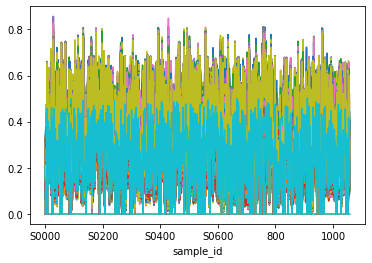

In [68]:
x_mean.plot(legend=False)

In [44]:
def qt(df,dist):
    ''' returns quantile transformed dataframe'''
    qt_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        df_mz_trans = quantile_transform(df_mz,random_state=RANDOM_SEED,output_distribution=dist)
        qt_df = pd.concat([qt_df,pd.DataFrame(df_mz_trans,index=df.index,columns=df_mz.columns)],axis=1)
    print(qt_df.shape)
    return qt_df

In [27]:
def rank_gauss(x):
    from scipy.special import erfinv
    N = x.shape[0]
    temp = x.argsort()
    rank_x = temp.argsort() / N
    rank_x -= rank_x.mean()
    rank_x *= 2
    efi_x = erfinv(rank_x)
    efi_x -= efi_x.mean()
    return efi_x

In [ ]:
for fold, (train_id, test_id) in enumerate(tqdm(skf.split(train_set_100,targets[phy]))):
    print('fold {}'.format(fold))
    X_train, X_test = train_set_100.iloc[train_id], train_set_100.iloc[test_id]
    y_train, y_test = targets[phy].iloc[train_id], targets[phy].iloc[test_id]
    X_train_trans = qt(X_train)
    X_test_trans = qt(X_test)
    

In [19]:
cb_clf = CatBoostClassifier(verbose=999,random_seed=RANDOM_SEED)

In [20]:
assert (train_set_100.columns == test_set_100.columns).all()

In [57]:
t_100 = get_total_abundance(train_set_100)
g_100 = get_grads(train_set_100)
m_100 = get_mean_std(train_set_100)
r_100 = get_relhe_abund(train_set_100)

 32%|███▏      | 32/100 [00:00<00:00, 158.84it/s]

(1059, 101)


 15%|█▌        | 15/100 [00:00<00:00, 139.22it/s]

(1059, 1500)


  0%|          | 0/100 [00:00<?, ?it/s]

(1059, 1800)


100%|██████████| 100/100 [00:09<00:00, 10.17it/s]


In [58]:
t_100_test = get_total_abundance(test_set_100)
g_100_test = get_grads(test_set_100)
m_100_test = get_mean_std(test_set_100)
r_100_test = get_relhe_abund(test_set_100)

 31%|███       | 31/100 [00:00<00:00, 151.75it/s]

(804, 101)


 14%|█▍        | 14/100 [00:00<00:00, 133.69it/s]

(804, 1500)


  1%|          | 1/100 [00:00<00:13,  7.43it/s]

(804, 1800)


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


In [59]:
t_100_test.sort_index(inplace=True,axis=1)
t_100.sort_index(inplace=True,axis=1)

m_100_test.sort_index(inplace=True,axis=1)
m_100.sort_index(inplace=True,axis=1)

g_100_test.sort_index(inplace=True,axis=1)
g_100.sort_index(inplace=True,axis=1)

r_100_test.sort_index(inplace=True,axis=1)
r_100.sort_index(inplace=True,axis=1)

In [60]:
assert (t_100.columns == t_100_test.columns).all()
assert (g_100.columns == g_100_test.columns).all()
assert (m_100.columns == m_100_test.columns).all()
assert (r_100.columns == r_100_test.columns).all()

In [61]:
ntrain = 1059
ntest = 804
NFOLDS = 5

In [ ]:
oof_train_df = pd.DataFrame(index=metadata[metadata.split != 'test'].index, columns=['sample_id',*targets.columns])
oof_test_df = pd.DataFrame(index=metadata[metadata.split != 'train'].index, columns=['sample_id',*targets.columns])

In [63]:
agg_loss = []
for target in targets.columns:
    print('TARGET ',target)
    imp_fts = {}
    
    #  get all imp coefs for the target
    t_100_coefs = get_coefs(t_100,targets[target],1)
    g_100_coefs = get_coefs(g_100,targets[target],5)
    m_100_coefs = get_coefs(m_100,targets[target],10)
    r_100_coefs = get_coefs(r_100,targets[target],1)
    o_100_coefs = get_coefs(train_set_100,targets[target],10)
    
    imp_fts['o_100_coefs'] = o_100_coefs
    imp_fts['t_100_coefs'] = t_100_coefs
    imp_fts['g_100_coefs'] = g_100_coefs
    imp_fts['m_100_coefs'] = m_100_coefs
    imp_fts['r_100_coefs'] = r_100_coefs

    # get all imp_dfs and concat them
    train_imp_ = train_set_100.iloc[:,o_100_coefs]
    t_100_imp_ = t_100.iloc[:,t_100_coefs]
    g_100_imp_ = g_100.iloc[:,g_100_coefs]
    m_100_imp_ = m_100.iloc[:,m_100_coefs]
    r_100_imp_ = r_100.iloc[:,r_100_coefs]

    print(train_imp_.shape,t_100_imp_.shape,g_100_imp_.shape,m_100_imp_.shape, r_100_imp_.shape)
    X = pd.concat([train_imp_,t_100_imp_,g_100_imp_,m_100_imp_,r_100_imp_],axis=1)
    print(X.shape)

    # same goes for test set
    test_imp_ = test_set_100.iloc[:,o_100_coefs]
    t_100_imp_test = t_100_test.iloc[:,t_100_coefs]
    g_100_imp_test = g_100_test.iloc[:,g_100_coefs]
    m_100_imp_test = m_100_test.iloc[:,m_100_coefs]
    r_100_imp_test = r_100_test.iloc[:,r_100_coefs]

    print(test_imp_.shape,t_100_imp_test.shape,g_100_imp_test.shape,m_100_imp_test.shape,r_100_imp_test.shape)
    
    X_test = pd.concat([test_imp_, t_100_imp_test, g_100_imp_test, m_100_imp_test, r_100_imp_test],axis=1)
    print(X_test.shape)
    
    # check for same cols in both train and test sets..
    assert (X.columns == X_test.columns).all()

    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    Y = targets[target]

    cb_clf = CatBoostClassifier(verbose=999,random_seed=RANDOM_SEED)
    cv_loss = []
    for fold, (train_id, test_id) in enumerate(tqdm(skf.split(X,Y))):

        #  ohh man unwanted semi colon in iloc throws an error...
        X_train, Y_train = X.iloc[train_id,], Y.iloc[train_id,]
        X_val, Y_val = X.iloc[test_id,], Y.iloc[test_id,]

        # upsampling works??
        upsampler = SMOTETomek(random_state=RANDOM_SEED)
        X_res, Y_res = upsampler.fit_resample(X_train, Y_train) 
        print(X_res.shape,Y_res.shape)
        
        assert (X_res.columns == X_val.columns).all
        
        # train model  and pred on oof folds
        # cb_clf.fit(X_res.values,Y_res)
        
        calib = CalibratedClassifierCV(cb_clf, cv = skf, ensemble=True, method='sigmoid')
        calib.fit(X_res.values,Y_res)
        y_preds = calib.predict_proba(X_val.values)[:,1]
        fold_loss = log_loss(Y_val,y_preds)
        print(f'fold Loss {fold}: ',fold_loss)
        cv_loss.append(fold_loss)

        oof_train[test_id] = y_preds
        oof_test_skf[fold,:] = calib.predict_proba(X_test.values)[:,1]

    print('Training Loss:', log_loss(Y,calib.predict_proba(X.values)[:,1]))
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test_df[target] = oof_test
    oof_train_df[target] = oof_train

    print(f'Loss for {target}:')
    print(np.array(cv_loss).mean(),np.array(cv_loss).std())
    agg_loss.append(np.array(cv_loss).mean())

    print("---------------------------------------------------------------------------------------------")

print('AGG Loss:',np.array(agg_loss))
print('AGG Loss mean:',np.array(agg_loss).mean())

TARGET  basalt


100%|██████████| 101/101 [00:00<00:00, 101759.48it/s]

0.3122080659673273
11



100%|██████████| 1500/1500 [00:00<00:00, 1427605.17it/s]

0.2875808538517409
54



  0%|          | 0/1800 [00:00<?, ?it/s]

0.26469583059665797


100%|██████████| 1800/1800 [00:00<00:00, 1817464.42it/s]


64


100%|██████████| 1600/1600 [00:00<00:00, 1642007.93it/s]

0.30109850825215095
24



100%|██████████| 1600/1600 [00:00<00:00, 1608168.32it/s]
0it [00:00, ?it/s]

0.26355293461316703
61
(1059, 61) (1059, 11) (1059, 54) (1059, 64) (1059, 24)
(1059, 214)
(804, 61) (804, 11) (804, 54) (804, 64) (804, 24)
(804, 214)
(1494, 214) (1494,)
Learning rate set to 0.011117
0:	learn: 0.6845493	total: 32.2ms	remaining: 32.2s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

999:	learn: 0.0182894	total: 30.6s	remaining: 0us
Learning rate set to 0.011117
0:	learn: 0.6840316	total: 30.2ms	remaining: 30.2s
999:	learn: 0.0196252	total: 30.9s	remaining: 0us
Learning rate set to 0.011117
0:	learn: 0.6845952	total: 30.8ms	remaining: 30.8s
999:	learn: 0.0173875	total: 30.7s	remaining: 0us
Learning rate set to 0.011117
0:	learn: 0.6846873	total: 29.8ms	remaining: 29.8s
999:	learn: 0.0178668	total: 31.8s	remaining: 0us
Learning rate set to 0.011121
0:	learn: 0.6841249	total: 29.1ms	remaining: 29s


1it [02:37, 157.85s/it]

999:	learn: 0.0172700	total: 32.2s	remaining: 0us
fold Loss 0:  0.14698039431826815
(1492, 214) (1492,)
Learning rate set to 0.011109
0:	learn: 0.6846164	total: 45ms	remaining: 45s
999:	learn: 0.0184541	total: 33.1s	remaining: 0us
Learning rate set to 0.011109
0:	learn: 0.6849938	total: 33.4ms	remaining: 33.4s
999:	learn: 0.0166942	total: 32.7s	remaining: 0us
Learning rate set to 0.011113
0:	learn: 0.6855678	total: 32.3ms	remaining: 32.3s
999:	learn: 0.0159906	total: 35.4s	remaining: 0us
Learning rate set to 0.011113
0:	learn: 0.6856551	total: 32.8ms	remaining: 32.8s
999:	learn: 0.0190296	total: 35.3s	remaining: 0us
Learning rate set to 0.011113
0:	learn: 0.6829337	total: 33.2ms	remaining: 33.1s


2it [05:31, 167.21s/it]

999:	learn: 0.0165949	total: 35.4s	remaining: 0us
fold Loss 1:  0.13339905107090017
(1498, 214) (1498,)
Learning rate set to 0.011128
0:	learn: 0.6857523	total: 34.6ms	remaining: 34.6s
999:	learn: 0.0203356	total: 34.9s	remaining: 0us
Learning rate set to 0.011128
0:	learn: 0.6837860	total: 32.5ms	remaining: 32.5s
999:	learn: 0.0180668	total: 34.9s	remaining: 0us
Learning rate set to 0.011128
0:	learn: 0.6841166	total: 34ms	remaining: 33.9s
999:	learn: 0.0171093	total: 34.7s	remaining: 0us
Learning rate set to 0.011132
0:	learn: 0.6827994	total: 31ms	remaining: 31s
999:	learn: 0.0194642	total: 37.3s	remaining: 0us
Learning rate set to 0.011132
0:	learn: 0.6862425	total: 33.1ms	remaining: 33.1s


3it [08:31, 172.78s/it]

999:	learn: 0.0193575	total: 35.7s	remaining: 0us
fold Loss 2:  0.1505327063219645
(1500, 214) (1500,)
Learning rate set to 0.011136
0:	learn: 0.6862143	total: 35.4ms	remaining: 35.4s
999:	learn: 0.0171974	total: 35.2s	remaining: 0us
Learning rate set to 0.011136
0:	learn: 0.6846942	total: 31.5ms	remaining: 31.4s
999:	learn: 0.0148030	total: 35.1s	remaining: 0us
Learning rate set to 0.011136
0:	learn: 0.6847405	total: 33.6ms	remaining: 33.5s
999:	learn: 0.0166465	total: 35s	remaining: 0us
Learning rate set to 0.011136
0:	learn: 0.6857395	total: 29.4ms	remaining: 29.4s


3it [10:48, 216.03s/it]


KeyboardInterrupt: 

In [ ]:
test_preds = oof_test_df.iloc[:293]
train_preds = oof_train_df.iloc[766:]

In [ ]:
agg_loss_train = []
for tar in targets.columns:
    loss = log_loss(val_labels[tar],train_preds[tar])
    print(tar, loss)
    agg_loss_train.append(loss)
print(np.array(agg_loss_train).mean())

In [ ]:
agg_loss_test = []
for tar in targets.columns:
    loss = log_loss(val_labels[tar],test_preds[tar])
    print(tar, loss)
    agg_loss_test.append(loss)
print(np.array(agg_loss_test).mean())